In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import os
from cea.utilities.dbf import dbf_to_dataframe

C:\Users\Reynold Mok\Documents\CityEnergyAnalyst3\Dependencies\Python\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
C:\Users\Reynold Mok\Documents\CityEnergyAnalyst3\Dependencies\Python\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


# Initial Setup
Sets up the path of input and output files

In [2]:
# Remember to put a `r` in front of path strings to prevent escape characters e.g. r'C:\path\to\file'

# Input Files
settlement_area_data_path = 'settlement_area.xlsx'
district_archetypes_data_path = 'district_archetypes.xlsx'
district_canton_data_path = 'district_canton.xlsx'

nexus_e_project_path = r'F:\CEA_SCRATCH\nexus-e'

# Output Files
output_path = '.\output'

if not os.path.exists(output_path):
    os.mkdir(output_path)

# Creating the master table
The following steps combine the data from district archetype with data about their settlement area

## Settlement area data
We get the settlement area by taking the district_area * settlement percentage

In [3]:
area_df = pd.read_excel(settlement_area_data_path, header=5).dropna().set_index('Gemeindecode')
area_df.columns = ['name', 'district_area', 'settlement_percentage']
# Add settlement area based on percentage
area_df['settlement_area'] = area_df['district_area'] * area_df['settlement_percentage'] / 100
area_df.head()

,name,district_area,settlement_percentage,settlement_area
Gemeindecode,,,,
1,Aeugst am Albis,7.91,12.6582,1.00127
2,Affoltern am Albis,10.59,30.6743,3.2484
3,Bonstetten,7.43,15.457,1.14845
4,Hausen am Albis,13.6,12.6926,1.72619
5,Hedingen,6.53,19.8171,1.29405


## District archetype data

In [4]:
archetypes_df = pd.read_excel(district_archetypes_data_path).set_index('BFS-NUMMER')
archetypes_df.head()

,Gemeinde,District,Rep-BFS
BFS-NUMMER,,,
4001,Aarau,Urban-1,Frauenfeld
4271,Aarburg,Urban-0,Rheinfelden
2761,Aesch (BL),Urban-0,Rheinfelden
2762,Allschwil,Urban-1,Frauenfeld
1201,Altdorf (UR),Urban-0,Rheinfelden


## Master table (merged)
We merge both tables using a left merge on their Gemeindecode/BFS-NUMMER, so only the districts found in the district archetype table are used.

Then rename the columns and try to clean the data due to the encoding/inconsistent naming of district names.

In [5]:
merged_df = pd.merge(archetypes_df, area_df, left_index=True, right_index=True, how='left').set_index(archetypes_df.index)
merged_df = merged_df[['name', 'District', 'Rep-BFS', 'settlement_area']]

merged_df = merged_df.astype({"name": "string", "District": "string", "Rep-BFS": "string", "settlement_area": float})

# Rename column and index name
merged_df.index.names = ["Gemeindecode"]
merged_df.columns = ['name', 'district_type', 'rep_name', 'settlement_area']

# Fix some errors
merged_df.loc[merged_df['rep_name'] == 'Gossau', 'rep_name'] = 'Gossau (ZH)'
merged_df.loc[merged_df['rep_name'] == u'Thöringen', 'rep_name'] = u'Thörigen'

merged_df.head()

,name,district_type,rep_name,settlement_area
Gemeindecode,,,,
4001,Aarau,Urban-1,Frauenfeld,6.070162
4271,Aarburg,Urban-0,Rheinfelden,2.014568
2761,Aesch (BL),Urban-0,Rheinfelden,2.650000
2762,Allschwil,Urban-1,Frauenfeld,3.821403
1201,Altdorf (UR),Urban-0,Rheinfelden,2.504907


### Filling missing settlement area values in Master table
Since we did a left merge on the district archetypes table, there will be some districts that would not be found in the settlement area data.

In [6]:
# Get districts that do no have settlement area data
missing_df = merged_df.loc[merged_df['settlement_area'].isna()]
missing_df

,name,district_type,rep_name,settlement_area
Gemeindecode,,,,
4272,<NA>,Rural-3,Endingen,NaN
2185,<NA>,Rural-3,Endingen,NaN
664,<NA>,Rural-3,Endingen,NaN
3691,<NA>,Rural-3,Endingen,NaN
134,<NA>,Rural-0,Thörigen,NaN
873,<NA>,Rural-3,Endingen,NaN
874,<NA>,Rural-3,Endingen,NaN
3926,<NA>,Rural-0,Thörigen,NaN
876,<NA>,Rural-1,Grandval,NaN


Below are the boxplots to show the range of values of settlement area based on district archetype.

Since the range of values for settlement area are relatively similar within each district type, we decided to fill the missing values with the averages of their district type

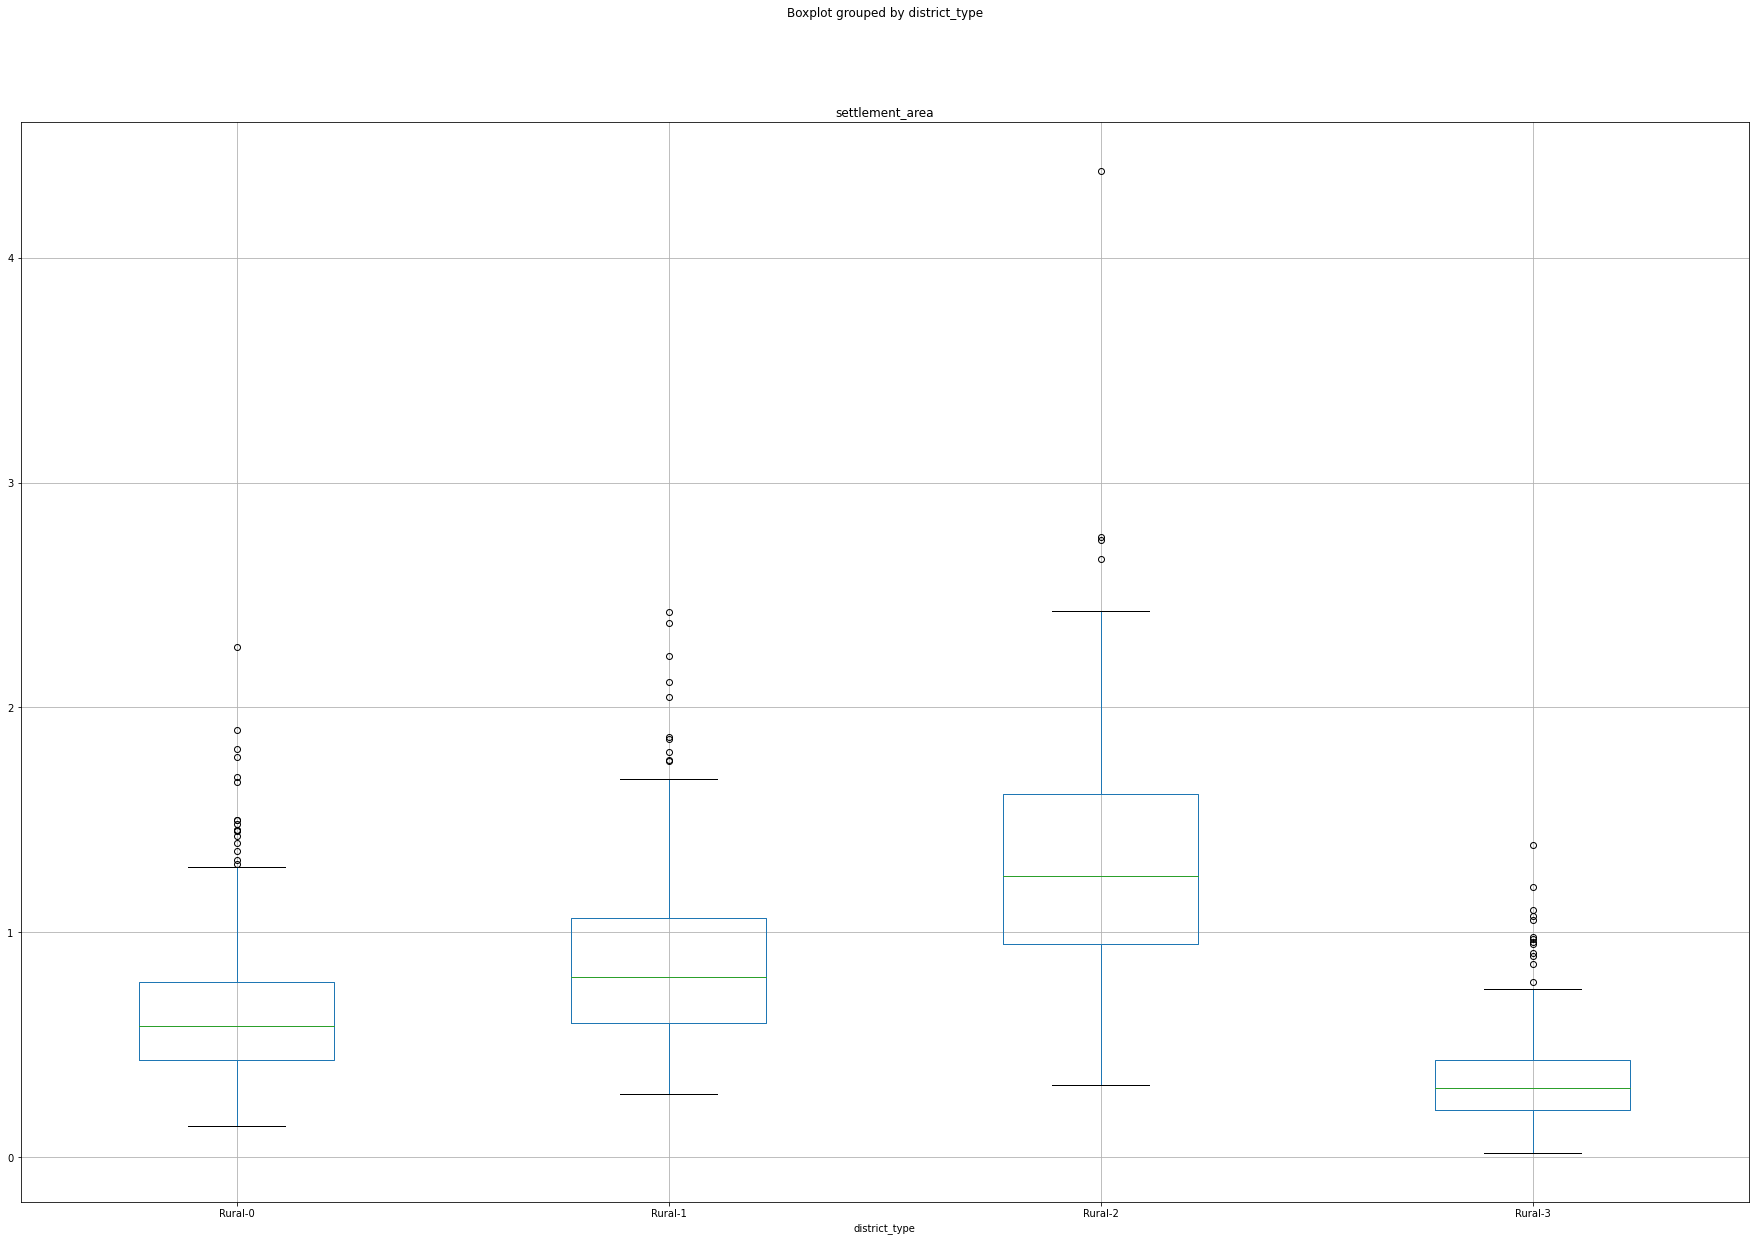

In [7]:
def show_box_plot_of_district_type(district_type):
    """
    Shows the range of values of settlement area in the district type
    """
    merged_df[merged_df.district_type.str.contains(district_type)].boxplot(by='district_type', column='settlement_area', figsize=(30,20))

show_box_plot_of_district_type('Rural')    

<AxesSubplot:title={'center':'settlement_area'}, xlabel='district_type'>

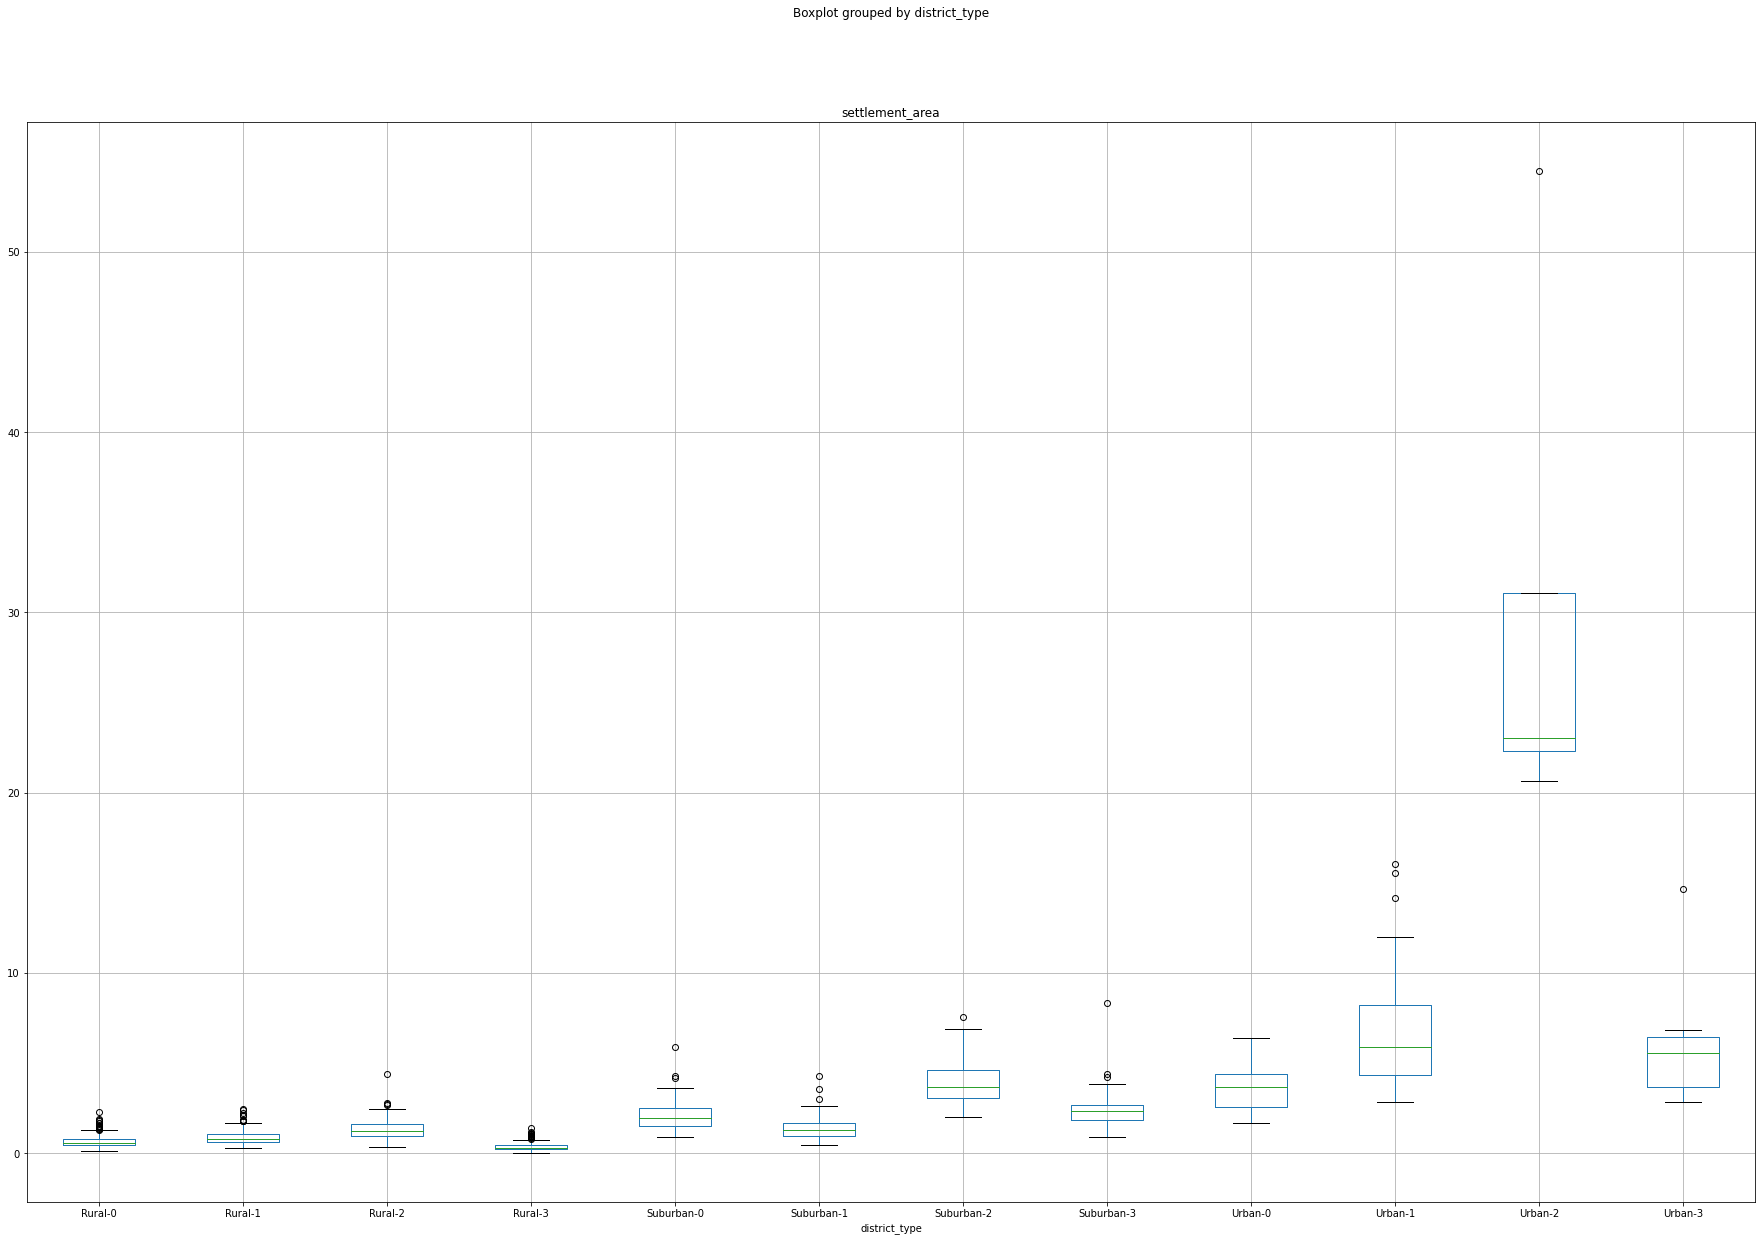

In [8]:
# Show boxplot of every district type by settlement area
merged_df.boxplot(by='district_type', column='settlement_area', figsize=(30,20))

In [9]:
# Average settlement area based on district archetype
average_settlement_df = merged_df.groupby('district_type')['settlement_area'].sum() / merged_df.groupby('district_type')['settlement_area'].count()
average_settlement_df

district_type
Rural-0        0.646321
Rural-1        0.884630
Rural-2        1.321585
Rural-3        0.342200
Suburban-0     2.080902
Suburban-1     1.351618
Suburban-2     3.932430
Suburban-3     2.356425
Urban-0        3.661249
Urban-1        6.715074
Urban-2       30.308874
Urban-3        6.112713
Name: settlement_area, dtype: float64

In [10]:
# Fill missing values using average values table
merged_df.loc[merged_df['settlement_area'].isna(), 'settlement_area'] = missing_df.apply(lambda x: average_settlement_df[x['district_type']], axis=1)
sum(merged_df['settlement_area'].isna())

0

In [11]:
# District archetypes table
district_type_df = merged_df[merged_df['name'] == merged_df['rep_name']].sort_values('district_type')
district_type_df

,name,district_type,rep_name,settlement_area
Gemeindecode,,,,
989,Thörigen,Rural-0,Thörigen,0.508882
694,Grandval,Rural-1,Grandval,0.350851
4776,Tobel-Tägerschen,Rural-2,Tobel-Tägerschen,0.940000
4305,Endingen,Rural-3,Endingen,1.056203
751,Täuffelen,Suburban-0,Täuffelen,1.027051
2932,Beringen,Suburban-1,Beringen,2.063314
785,Meiringen,Suburban-2,Meiringen,3.037010
115,Gossau (ZH),Suburban-3,Gossau (ZH),3.448668
4258,Rheinfelden,Urban-0,Rheinfelden,3.667713


In [12]:
# Get the ratio of settlement area with respect to its district type
merged_df['rep_settlement_ratio'] = merged_df.apply(lambda x: x['settlement_area'] / district_type_df[district_type_df['district_type'] == x['district_type']].iloc[0]['settlement_area'] ,axis=1)
merged_df.head()

,name,district_type,rep_name,settlement_area,rep_settlement_ratio
Gemeindecode,,,,,
4001,Aarau,Urban-1,Frauenfeld,6.070162,0.737209
4271,Aarburg,Urban-0,Rheinfelden,2.014568,0.549271
2761,Aesch (BL),Urban-0,Rheinfelden,2.650000,0.722521
2762,Allschwil,Urban-1,Frauenfeld,3.821403,0.464101
1201,Altdorf (UR),Urban-0,Rheinfelden,2.504907,0.682961


In [13]:
merged_df.describe(include='all')

,name,district_type,rep_name,settlement_area,rep_settlement_ratio
count,2020,2044,2044,2044.000000,2044.000000
unique,2020,12,12,NaN,NaN
top,Ittigen,Rural-3,Endingen,NaN,NaN
freq,1,482,482,NaN,NaN
mean,NaN,NaN,NaN,1.352087,1.160534
std,NaN,NaN,NaN,2.016339,0.935388
min,NaN,NaN,NaN,0.020026,0.018960
25%,NaN,NaN,NaN,0.452567,0.467764
50%,NaN,NaN,NaN,0.846457,0.899088
75%,NaN,NaN,NaN,1.621118,1.569091


# Getting total demand of Switzerland
These steps will only work assuming the following:
- The project folder is in the correct structure with the scenario names as the district archetype district name (see below for examples).
- Ran the aggregation script (folder named `aggregate` created in the scenario folder) and have the `total_demand.csv` inside.

In [14]:
def get_total_demand(district):
    total_demand_path = os.path.join(nexus_e_project_path, r"{}-switzerland\aggregate\total_demand.csv".format(district))
    total_demand_df = pd.read_csv(total_demand_path, header=None, names=['property', 'values']).sort_values('property').set_index('property')
    return total_demand_df['values']

In [15]:
# Read the total demand files of each district archetype and store them in a dict
mapping_dict = {
    'Rural-0': get_total_demand('thrigen'),
    'Rural-1': get_total_demand('grandval'),
    'Rural-2': get_total_demand('tobel-tagerschen'),
    'Rural-3': get_total_demand('endingen'),
    'Suburban-0': get_total_demand('tauffelen'),
    'Suburban-1': get_total_demand('beringen'),
    'Suburban-2': get_total_demand('meiringen'),
    'Suburban-3': get_total_demand('gossau'),
    'Urban-0': get_total_demand('rheinfelden'),
    'Urban-1': get_total_demand('frauenfeld'),
    'Urban-2': get_total_demand('basel'),
    'Urban-3': get_total_demand('grenchen'),
}
mapping_dict

{'Rural-0': property
 Af_m2            182536.892
 Aocc_m2          263701.716
 Aroof_m2          96315.780
 COAL_hs0_kW           0.000
 COAL_hs_MWhyr         0.000
                     ...    
 WOOD_hs0_kW        4985.559
 WOOD_hs_MWhyr      4619.814
 WOOD_ww0_kW         163.230
 WOOD_ww_MWhyr       619.275
 people0            4919.000
 Name: values, Length: 163, dtype: float64,
 'Rural-1': property
 Af_m2             73282.632
 Aocc_m2          106889.819
 Aroof_m2          40437.950
 COAL_hs0_kW           0.000
 COAL_hs_MWhyr         0.000
                     ...    
 WOOD_hs0_kW        1681.060
 WOOD_hs_MWhyr      3368.333
 WOOD_ww0_kW         101.410
 WOOD_ww_MWhyr       401.306
 people0            2030.000
 Name: values, Length: 163, dtype: float64,
 'Rural-2': property
 Af_m2            304317.840
 Aocc_m2          441936.090
 Aroof_m2         162252.560
 COAL_hs0_kW           0.000
 COAL_hs_MWhyr         0.000
                     ...    
 WOOD_hs0_kW        6560.691
 WOOD_hs

In [16]:
# Get demand of each district by multiplying demand values with the ratio
district_demand_df = merged_df.apply(lambda x: mapping_dict[x['district_type']] * x['rep_settlement_ratio'] ,axis=1)
district_demand_df

,Af_m2,Aocc_m2,Aroof_m2,COAL_hs0_kW,COAL_hs_MWhyr,COAL_ww0_kW,COAL_ww_MWhyr,DC_cdata0_kW,DC_cdata_MWhyr,DC_cre0_kW,...,Qww_sys_MWhyr,SOLAR_hs0_kW,SOLAR_hs_MWhyr,SOLAR_ww0_kW,SOLAR_ww_MWhyr,WOOD_hs0_kW,WOOD_hs_MWhyr,WOOD_ww0_kW,WOOD_ww_MWhyr,people0
Gemeindecode,,,,,,,,,,,,,,,,,,,,,
4001,2.666891e+06,3.667163e+06,1.210405e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.090228e+07,0.0,0.0,0.0,0.0,8710.759794,12998.375475,947.733291,3564.154522,1.276078e+07
4271,7.842429e+05,1.081144e+06,3.601372e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.919885e+04,0.0,0.0,0.0,0.0,1390.969194,901.376042,101.787585,299.184006,3.872470e+04
2761,1.031607e+06,1.422156e+06,4.737311e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.525451e+04,0.0,0.0,0.0,0.0,1829.706435,1185.686607,133.893259,393.552138,5.093918e+04
2762,1.678911e+06,2.308622e+06,7.619968e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.863407e+06,0.0,0.0,0.0,0.0,5483.762036,8182.982844,596.634962,2243.773875,8.033408e+06
1201,9.751247e+05,1.344290e+06,4.477933e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.387177e+04,0.0,0.0,0.0,0.0,1729.526052,1120.767702,126.562314,372.004308,4.815015e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2869,3.441494e+05,4.758029e+05,1.594363e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.627942e+03,0.0,0.0,0.0,0.0,2930.092191,3810.672087,167.101563,604.401927,1.547947e+04
3426,5.923489e+05,8.358313e+05,2.944247e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.744283e+04,0.0,0.0,0.0,0.0,3325.339175,6283.278324,221.148818,869.086329,2.066043e+04
794,7.734485e+05,1.119148e+06,4.142001e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.569576e+04,0.0,0.0,0.0,0.0,3469.805572,6142.149386,229.675568,901.700919,2.453896e+04


In [17]:
# Sum to get total demand of Switzerland
final_df = district_demand_df.sum()
final_df

Af_m2            1.025419e+09
Aocc_m2          1.425257e+09
Aroof_m2         4.798705e+08
COAL_hs0_kW      0.000000e+00
COAL_hs_MWhyr    0.000000e+00
                     ...     
WOOD_hs0_kW      9.570933e+06
WOOD_hs_MWhyr    1.315641e+07
WOOD_ww0_kW      5.033984e+05
WOOD_ww_MWhyr    1.928071e+06
people0          6.434830e+08
Length: 167, dtype: float64

In [18]:
final_df.to_csv(os.path.join(output_path, 'total_demand.csv'))

In [19]:
# demand_glossary = pd.read_csv(r'F:\CEA_SCRATCH\nexus-e\demand_glossary.csv', header=None, names=['property', 'description']).sort_values('property').set_index('property')
# _out = final_df.to_frame()
# _out.columns = ['value']
# pd.merge(demand_glossary, _out, left_index=True, right_index=True).to_csv('total_demand_with_descriptions.csv')

# Futher steps (Optional)
Below are functions to separate total demand and pv potentials, of each district(scenario), based on building type and canton for futher analysis.

This would require the typology file of the district(scenario), which describes the types of each building. And also require the original output data of each simulation (not the aggregated values from the `aggregate` script)

When aggregating values into cantons by building type, we assume that each district will have the same building type ratios as their district archetype.

In [20]:
 def get_demand_split_func(total_demand):
    def split_building_type(building_name, bt1, bt2, bt3, br1, br2, br3):
        building_demand = total_demand.loc[building_name]
        df_list = []
        for index, building_type, building_ratio in zip([1,2,3], [bt1, bt2, bt3], [br1, br2, br3]):
            if building_type != 'NONE':
                type_demand = building_demand * building_ratio
                type_demand['building_type'] = building_type
                type_demand['building_name'] = building_name
                df_list.append(type_demand)
            else:
                return pd.DataFrame(df_list)
    return split_building_type

def get_building_type_demand(district):
    typology_path = os.path.join(nexus_e_project_path, r'{}-switzerland\inputs\building-properties\typology.dbf'.format(district))
    total_demand_path = os.path.join(nexus_e_project_path, r'{}-switzerland\outputs\data\demand\Total_demand.csv'.format(district))
    typology_df = dbf_to_dataframe(typology_path).set_index('Name')
    total_demand = pd.read_csv(total_demand_path, index_col='Name')
    
    split_func = get_demand_split_func(total_demand)
    
    demand_building_type_df = [split_func(building_name, bt1, bt2, bt3, br1, br2, br3) 
           for building_name, bt1, bt2, bt3, br1, br2, br3
           in zip(typology_df.index, typology_df['1ST_USE'], typology_df['2ND_USE'], typology_df['3RD_USE'], 
                  typology_df['1ST_USE_R'], typology_df['2ND_USE_R'], typology_df['3RD_USE_R'])]

    combine_df = pd.concat(demand_building_type_df, ignore_index=True)
    out_path = os.path.join(output_path, 'demand_by_type')
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    combine_df.groupby('building_type').sum().to_csv(os.path.join(out_path, r'{}.csv'.format(district)))

In [21]:
def get_pv_split_func(total_pv):
    def split_building_type(building_name, bt1, bt2, bt3, br1, br2, br3):
        building_pv = total_pv.loc[building_name]
        df_list = []
        for index, building_type, building_ratio in zip([1,2,3], [bt1, bt2, bt3], [br1, br2, br3]):
            if building_type != 'NONE':
                type_pv = building_pv * building_ratio
                type_pv['building_type'] = building_type
                type_pv['building_name'] = building_name
                df_list.append(type_pv)
            else:
                return pd.DataFrame(df_list)
    return split_building_type

def get_building_type_pv(district):
    typology_path = os.path.join(nexus_e_project_path, r'{}-switzerland\inputs\building-properties\typology.dbf'.format(district))
    total_pv_path = os.path.join(nexus_e_project_path, r'{}-switzerland\outputs\data\potentials\solar\PV_total_buildings.csv'.format(district))
    typology_df = dbf_to_dataframe(typology_path).set_index('Name')
    total_pv = pd.read_csv(total_pv_path, index_col='Name')
    
    split_func = get_pv_split_func(total_pv)
    
    pv_building_type_df = [split_func(building_name, bt1, bt2, bt3, br1, br2, br3) 
           for building_name, bt1, bt2, bt3, br1, br2, br3
           in zip(typology_df.index, typology_df['1ST_USE'], typology_df['2ND_USE'], typology_df['3RD_USE'], 
                  typology_df['1ST_USE_R'], typology_df['2ND_USE_R'], typology_df['3RD_USE_R'])]

    combine_df = pd.concat(pv_building_type_df, ignore_index=True)
    out_path = os.path.join(output_path, 'pv_by_type')
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    combine_df.groupby('building_type').sum().to_csv(os.path.join(out_path, r'{}.csv'.format(district)))

## Create files by building type of each district type
The following steps will go through each district and create files that describe demand/pv of each district archetype by building type

_It might take awhile to finish running_ (Remember to uncomment the cells to run it)

In [22]:
districts = ['thrigen','grandval','tobel-tagerschen',
 'endingen','tauffelen','beringen',
 'meiringen','gossau','rheinfelden',
 'frauenfeld','basel','grenchen']

In [23]:
# Uncomment below to run

# for district in districts:
#     get_building_type_demand(district)
#     print(district)

In [24]:
# Uncomment below to run

# for district in districts:
#     get_building_type_pv(district)
#     print(district)

## District-Canton data

In [25]:
# Get demand based on canton
rep_ratio_df = merged_df[['name', 'district_type', 'rep_settlement_ratio']]

dc_map_df = pd.read_excel(district_canton_data_path, sheet_name='GDE')[['GDEKT', 'GDEKTNA', 'GDENR', 'GDENAME']].set_index('GDENR')
dc_map_df = rep_ratio_df.merge(dc_map_df, how='left', left_index=True, right_index=True)
dc_map_df

,name,district_type,rep_settlement_ratio,GDEKT,GDEKTNA,GDENAME
Gemeindecode,,,,,,
4001,Aarau,Urban-1,0.737209,AG,Aargau,Aarau
4271,Aarburg,Urban-0,0.549271,AG,Aargau,Aarburg
2761,Aesch (BL),Urban-0,0.722521,BL,Basel-Landschaft,Aesch (BL)
2762,Allschwil,Urban-1,0.464101,BL,Basel-Landschaft,Allschwil
1201,Altdorf (UR),Urban-0,0.682961,UR,Uri,Altdorf (UR)
...,...,...,...,...,...,...
2869,Zunzgen,Suburban-1,0.397419,BL,Basel-Landschaft,Zunzgen
3426,Zuzwil (SG),Suburban-3,0.519041,SG,St. Gallen,Zuzwil (SG)
794,Zweisimmen,Suburban-0,2.419777,BE,Bern,Zweisimmen


In [26]:
missing_dc = dc_map_df[dc_map_df['GDEKT'].isnull()]
missing_dc[['name', 'district_type', 'GDEKT']].to_csv(os.path.join(output_path, 'missing_districts.csv'))
missing_dc.sort_index()

,name,district_type,rep_settlement_ratio,GDEKT,GDEKTNA,GDENAME
Gemeindecode,,,,,,
36,<NA>,Rural-1,2.521387,NaN,NaN,NaN
42,<NA>,Rural-0,1.270080,NaN,NaN,NaN
44,<NA>,Rural-0,1.270080,NaN,NaN,NaN
134,<NA>,Rural-0,1.270080,NaN,NaN,NaN
140,<NA>,Rural-1,2.521387,NaN,NaN,NaN
142,<NA>,Suburban-2,1.294836,NaN,NaN,NaN
664,<NA>,Rural-3,0.323991,NaN,NaN,NaN
873,<NA>,Rural-3,0.323991,NaN,NaN,NaN
874,<NA>,Rural-3,0.323991,NaN,NaN,NaN


In [27]:
# Ignore districts without canton
dc_map_df = dc_map_df[dc_map_df['GDEKT'].notnull()]

In [28]:
def get_split_demand(district):
    split_demand_path = os.path.join(output_path, 'demand_by_type', "{}-switzerland.csv".format(district))
    split_demand_df = pd.read_csv(split_demand_path).set_index('building_type')
    return split_demand_df

def get_split_pv(district):
    split_pv_path = os.path.join(output_path, 'pv_by_type', "{}-switzerland.csv".format(district))
    split_pv_df = pd.read_csv(split_pv_path).set_index('building_type')
    return split_pv_df

def get_hourly_demand(district):
    hourly_demand_path = os.path.join(nexus_e_project_path, r"{}-switzerland\aggregate\hourly_demand.csv".format(district))
    hourly_demand_df = pd.read_csv(hourly_demand_path, parse_dates=['DATE']).set_index('DATE')
    return hourly_demand_df

def get_hourly_pv(district):
    hourly_pv_path = os.path.join(nexus_e_project_path, r"{}-switzerland\outputs\data\potentials\solar\PV_total.csv".format(district))
    hourly_pv_df = pd.read_csv(hourly_pv_path, parse_dates=['Date']).set_index('Date')
    return hourly_pv_df

In [29]:
split_demand_mapping_dict = {
    'Rural-0': get_split_demand('thrigen'),
    'Rural-1': get_split_demand('grandval'),
    'Rural-2': get_split_demand('tobel-tagerschen'),
    'Rural-3': get_split_demand('endingen'),
    'Suburban-0': get_split_demand('tauffelen'),
    'Suburban-1': get_split_demand('beringen'),
    'Suburban-2': get_split_demand('meiringen'),
    'Suburban-3': get_split_demand('gossau'),
    'Urban-0': get_split_demand('rheinfelden'),
    'Urban-1': get_split_demand('frauenfeld'),
    'Urban-2': get_split_demand('basel'),
    'Urban-3': get_split_demand('grenchen'),
}
split_demand_mapping_dict

{'Rural-0':                     Af_m2  Aroof_m2      GFA_m2     Aocc_m2  people0  \
 building_type                                                          
 INDUSTRIAL       2528.774   1668.67    4710.162    3862.332    203.0   
 MULTI_RES       53897.678  24624.86   90888.857   74528.863   1946.0   
 SINGLE_RES     126110.440  70022.25  225988.442  185310.521   2770.0   
 
                GRID_ww_MWhyr  Qhs_sen_ahu_MWhyr  GRID_l0_kW  Ea_MWhyr  \
 building_type                                                           
 INDUSTRIAL             0.000                0.0      35.038   143.184   
 MULTI_RES            701.153                0.0     165.004  1166.469   
 SINGLE_RES           674.134                0.0     410.276  2900.332   
 
                Qcs_sys_MWhyr  ...  Qww_MWhyr  Qcpro_sys0_kW   Qhs0_kW  \
 building_type                 ...                                       
 INDUSTRIAL               0.0  ...      9.405            0.0   385.800   
 MULTI_RES                0.

In [30]:
split_pv_mapping_dict = {
    'Rural-0': get_split_pv('thrigen'),
    'Rural-1': get_split_pv('grandval'),
    'Rural-2': get_split_pv('tobel-tagerschen'),
    'Rural-3': get_split_pv('endingen'),
    'Suburban-0': get_split_pv('tauffelen'),
    'Suburban-1': get_split_pv('beringen'),
    'Suburban-2': get_split_pv('meiringen'),
    'Suburban-3': get_split_pv('gossau'),
    'Urban-0': get_split_pv('rheinfelden'),
    'Urban-1': get_split_pv('frauenfeld'),
    'Urban-2': get_split_pv('basel'),
    'Urban-3': get_split_pv('grenchen'),
}
split_pv_mapping_dict

{'Rural-0':                PV_walls_south_E_kWh  PV_walls_north_E_kWh  PV_roofs_top_E_kWh  \
 building_type                                                                   
 INDUSTRIAL                 11828.93                   0.0            77339.37   
 MULTI_RES                 507769.06                   0.0          4330453.46   
 SINGLE_RES               2726715.01                   0.0         26628658.43   
 
                PV_walls_east_E_kWh  PV_walls_west_E_kWh  E_PV_gen_kWh  \
 building_type                                                           
 INDUSTRIAL                    0.00                 0.00      89168.66   
 MULTI_RES                  5541.93             23322.29    4867088.58   
 SINGLE_RES                28198.21            240393.93   29623964.08   
 
                radiation_kWh  PV_walls_south_m2  PV_walls_north_m2  \
 building_type                                                        
 INDUSTRIAL      6.950314e+05             102.46               

In [31]:
hourly_demand_mapping_dict = {
    'Rural-0': get_hourly_demand('thrigen'),
    'Rural-1': get_hourly_demand('grandval'),
    'Rural-2': get_hourly_demand('tobel-tagerschen'),
    'Rural-3': get_hourly_demand('endingen'),
    'Suburban-0': get_hourly_demand('tauffelen'),
    'Suburban-1': get_hourly_demand('beringen'),
    'Suburban-2': get_hourly_demand('meiringen'),
    'Suburban-3': get_hourly_demand('gossau'),
    'Urban-0': get_hourly_demand('rheinfelden'),
    'Urban-1': get_hourly_demand('frauenfeld'),
    'Urban-2': get_hourly_demand('basel'),
    'Urban-3': get_hourly_demand('grenchen'),
}
hourly_demand_mapping_dict

{'Rural-0':                      people     x_int  PV_kWh  GRID_kWh  GRID_a_kWh  \
 DATE                                                                  
 2005-01-01 00:00:00  4716.0  2026.527     0.0   550.453     215.601   
 2005-01-01 01:00:00  4716.0  1961.384     0.0   567.310     215.601   
 2005-01-01 02:00:00  4716.0  1901.388     0.0   584.124     215.601   
 2005-01-01 03:00:00  4716.0  1852.686     0.0   615.655     215.601   
 2005-01-01 04:00:00  4716.0  1812.281     0.0   628.922     215.601   
 ...                     ...       ...     ...       ...         ...   
 2005-12-31 19:00:00  3800.0  1808.512     0.0  2897.058    1712.273   
 2005-12-31 20:00:00  3800.0  1885.129     0.0  1075.837     381.890   
 2005-12-31 21:00:00  4716.0  1988.622     0.0   778.838     381.890   
 2005-12-31 22:00:00  4716.0  2059.975     0.0   772.737     381.890   
 2005-12-31 23:00:00  4716.0  2110.277     0.0   532.338     215.601   
 
                      GRID_l_kWh  GRID_v_kWh  GRID_

In [32]:
hourly_pv_mapping_dict = {
    'Rural-0': get_hourly_pv('thrigen'),
    'Rural-1': get_hourly_pv('grandval'),
    'Rural-2': get_hourly_pv('tobel-tagerschen'),
    'Rural-3': get_hourly_pv('endingen'),
    'Suburban-0': get_hourly_pv('tauffelen'),
    'Suburban-1': get_hourly_pv('beringen'),
    'Suburban-2': get_hourly_pv('meiringen'),
    'Suburban-3': get_hourly_pv('gossau'),
    'Urban-0': get_hourly_pv('rheinfelden'),
    'Urban-1': get_hourly_pv('frauenfeld'),
    'Urban-2': get_hourly_pv('basel'),
    'Urban-3': get_hourly_pv('grenchen'),
}
hourly_pv_mapping_dict

{'Rural-0':                            PV_walls_south_E_kWh  PV_walls_south_m2  \
 Date                                                                 
 2005-01-01 00:00:00+01:00                   0.0           20877.57   
 2005-01-01 01:00:00+01:00                   0.0           20877.57   
 2005-01-01 02:00:00+01:00                   0.0           20877.57   
 2005-01-01 03:00:00+01:00                   0.0           20877.57   
 2005-01-01 04:00:00+01:00                   0.0           20877.57   
 ...                                         ...                ...   
 2005-12-31 19:00:00+01:00                   0.0           20877.57   
 2005-12-31 20:00:00+01:00                   0.0           20877.57   
 2005-12-31 21:00:00+01:00                   0.0           20877.57   
 2005-12-31 22:00:00+01:00                   0.0           20877.57   
 2005-12-31 23:00:00+01:00                   0.0           20877.57   
 
                            PV_walls_north_E_kWh  PV_walls_north

In [33]:
from functools import reduce

# Group results by canton
for name, group in dc_map_df.groupby(['GDEKT', 'GDEKTNA']):
    print(name)
    ratio_tuples = list(zip(group['district_type'], group['rep_settlement_ratio']))
    
    # Write canton demand by type to file
    demand_split_list = [split_demand_mapping_dict[district_type] * ratio for district_type, ratio in ratio_tuples]
    total_demad_split_df = reduce(lambda x, y: x.add(y, fill_value=0.0), demand_split_list)
    out_path = os.path.join(output_path, 'canton_demand_by_type')
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    total_demad_split_df.to_csv(os.path.join(out_path, '{}.csv'.format(name[0])))
    
    # Write canton pv by type to file
    pv_split_list = [split_pv_mapping_dict[district_type] * ratio for district_type, ratio in ratio_tuples]
    total_pv_split_df = reduce(lambda x, y: x.add(y, fill_value=0.0), pv_split_list)
    out_path = os.path.join(output_path, 'canton_pv_by_type')
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    total_pv_split_df.to_csv(os.path.join(out_path, '{}.csv'.format(name[0])))
    
    # Write canton hourly demand to file
    hourly_demand_list = [hourly_demand_mapping_dict[district_type] * ratio for district_type, ratio in ratio_tuples]
    total_hourly_demand_df = reduce(lambda x, y: x + y, hourly_demand_list)
    out_path = os.path.join(output_path, 'canton_hourly_demand')
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    total_hourly_demand_df.to_csv(os.path.join(out_path, '{}.csv'.format(name[0])))
    
    # Write canton hourly pv o file
    hourly_pv_list = [hourly_pv_mapping_dict[district_type] * ratio for district_type, ratio in ratio_tuples]
    total_hourly_pv_df = reduce(lambda x, y: x + y, hourly_pv_list)
    out_path = os.path.join(output_path, 'canton_hourly_pv')
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    total_hourly_pv_df.to_csv(os.path.join(out_path, '{}.csv'.format(name[0])))

('AG', 'Aargau')
('AI', 'Appenzell Innerrhoden')
('AR', 'Appenzell Ausserrhoden')
('BE', 'Bern')
('BL', 'Basel-Landschaft')
('BS', 'Basel-Stadt')
('FR', 'Fribourg')
('GE', 'Genève')
('GL', 'Glarus')
('GR', 'Graubünden')
('JU', 'Jura')
('LU', 'Luzern')
('NE', 'Neuchâtel')
('NW', 'Nidwalden')
('OW', 'Obwalden')
('SG', 'St. Gallen')
('SH', 'Schaffhausen')
('SO', 'Solothurn')
('SZ', 'Schwyz')
('TG', 'Thurgau')
('TI', 'Ticino')
('UR', 'Uri')
('VD', 'Vaud')
('VS', 'Valais')
('ZG', 'Zug')
('ZH', 'Zürich')


In [34]:
import glob
caton_demand_split_list = [pd.read_csv(x).set_index('building_type') for x in glob.glob(os.path.join(output_path, 'canton_demand_by_type','*.csv'))]
reduce(lambda x, y: x.add(y, fill_value=0.0), caton_demand_split_list).to_csv(os.path.join(output_path, 'switzerland_demand_by_type.csv'))

caton_pv_split_list = [pd.read_csv(x).set_index('building_type') for x in glob.glob(os.path.join(output_path, 'canton_pv_by_type','*.csv'))]
reduce(lambda x, y: x.add(y, fill_value=0.0), caton_pv_split_list).to_csv(os.path.join(output_path, 'switzerland_pv_by_type.csv'))


caton_hourly_demand_list = [pd.read_csv(x, parse_dates=['DATE']).set_index('DATE') for x in glob.glob(os.path.join(output_path, 'canton_hourly_demand','*.csv'))]
reduce(lambda x, y: x.add(y, fill_value=0.0), caton_hourly_demand_list).to_csv(os.path.join(output_path, 'switzerland_hourly_demand.csv'))

caton_hourly_pv_list = [pd.read_csv(x, parse_dates=['Date']).set_index('Date') for x in glob.glob(os.path.join(output_path, 'canton_hourly_pv','*.csv'))]
reduce(lambda x, y: x.add(y, fill_value=0.0), caton_hourly_pv_list).to_csv(os.path.join(output_path, 'switzerland_hourly_pv.csv'))